In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

from tensorboard.notebook import display


## Ignoring Warnings

In [50]:
warnings.filterwarnings('ignore')

## Loading and Viewing Data

In [51]:
df = pd.read_csv('data/personal_finance_employees_V2.csv')
df.head()

,Employee,Monthly Income (£),Electricity Bill (£),Gas Bill (£),Netflix (£),Amazon Prime (£),Groceries (£),Transportation (£),Water Bill (£),Sky Sports (£),Other Expenses (£),Savings for Property (£),Monthly Outing (£)
0,Employee_1,4999.39,120.000000,80.0000,12.0,4.99,239.69000,149.11000,40.0,70.0,100.000000,300.0,120.0
1,Employee_2,4660.24,120.000000,80.0000,12.0,4.99,226.24000,197.23000,40.0,70.0,100.000000,300.0,120.0
2,Employee_3,1942.89,124.679456,98.1346,12.0,4.99,333.77745,201.27956,40.0,70.0,125.770693,0.0,120.0
3,Employee_4,3565.80,120.000000,80.0000,12.0,4.99,213.04000,154.67000,40.0,0.0,100.000000,300.0,120.0
4,Employee_5,5121.99,120.000000,80.0000,12.0,4.99,182.56000,190.71000,40.0,70.0,100.000000,300.0,0.0


## Calculating Financial Ratios

In [52]:
def analyze_employee_finances(df, employee_id): 
    employee = df[df['Employee'] == employee_id].iloc[0]
    
    # Calculate key metrics
    total_expenses = sum([
        employee['Electricity Bill (£)'],
        employee['Gas Bill (£)'],
        employee['Netflix (£)'],
        employee['Amazon Prime (£)'],
        employee['Groceries (£)'],
        employee['Transportation (£)'],
        employee['Water Bill (£)'],
        employee['Sky Sports (£)'] ,
        employee['Other Expenses (£)'] ,
        employee['Monthly Outing (£)'] 
    ])
    
    # Calculate percentages
    expenses_breakdown = {
        'Cost of living': (employee['Electricity Bill (£)'] + employee['Gas Bill (£)'] + 
                     (employee['Water Bill (£)'])),
        'Entertainment': (employee['Netflix (£)'] + employee['Amazon Prime (£)'] + 
                        (employee['Sky Sports (£)'] ) +
                        (employee['Monthly Outing (£)'])),
        'Essentials': employee['Groceries (£)'] + employee['Transportation (£)'],
        'Other': employee['Other Expenses (£)']
    }
    
    savings = employee['Savings for Property (£)'] if not np.isnan(employee['Savings for Property (£)']) else 0
    
    # Calculate financial ratios
    financial_health = {
        'Income': employee['Monthly Income (£)'],
        'Total Expenses': total_expenses,
        'Savings': savings,
        'Disposable Income': employee['Monthly Income (£)'] - total_expenses - savings,
        'Savings Rate': (savings / employee['Monthly Income (£)']) * 100 if savings > 0 else 0,
        'Expense Ratio': (total_expenses / employee['Monthly Income (£)']) * 100,
        'Essential Expenses Ratio': ((expenses_breakdown['Cost of living'] + expenses_breakdown['Essentials']) / 
                                   employee['Monthly Income (£)']) * 100
    }
    return financial_health, expenses_breakdown

personal_dashboard = analyze_employee_finances(df, 'Employee_4')
display(f"Financial Dashboard for Employee 4: {personal_dashboard}")

"Financial Dashboard for Employee 4: ({'Income': 3565.8, 'Total Expenses': 844.6999999999999, 'Savings': 300.0, 'Disposable Income': 2421.1000000000004, 'Savings Rate': 8.413259296651523, 'Expense Ratio': 23.688933759605135, 'Essential Expenses Ratio': 17.042739357226992}, {'Cost of living': 240.0, 'Entertainment': 136.99, 'Essentials': 367.71, 'Other': 100.0})"

## Analyzing Financial Generalized Data

In [53]:
def calculate_financial_metrics(df): 
    expense_columns = [col for col in df.columns if col not in ['Employee', 'Monthly Income (£)', 'Savings for Property (£)']]
    df['Total Expenses'] = df[expense_columns].sum(axis=1)
    
    # Calculate savings rate
    df['Savings Rate'] = (df['Savings for Property (£)'].fillna(0) / df['Monthly Income (£)']) * 100
    
    # Calculate disposable income
    df['Disposable Income'] = df['Monthly Income (£)'] - df['Total Expenses']
    return df 

df = calculate_financial_metrics(df)

## Clustering Employee Spending Habits

In [54]:
def perform_clustering(df, n_clusters=3):
    features = ['Monthly Income (£)', 'Total Expenses', 'Savings Rate']
    X = df[features]

    # Standardize the data before clustering to have all numerical features on the same scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform KMeans clustering to identify spending habits
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['Spending Cluster'] = kmeans.fit_predict(X_scaled)
    
    return df, kmeans.cluster_centers_

df, cluster_centers = perform_clustering(df)

## Analyzing Financial Metrics


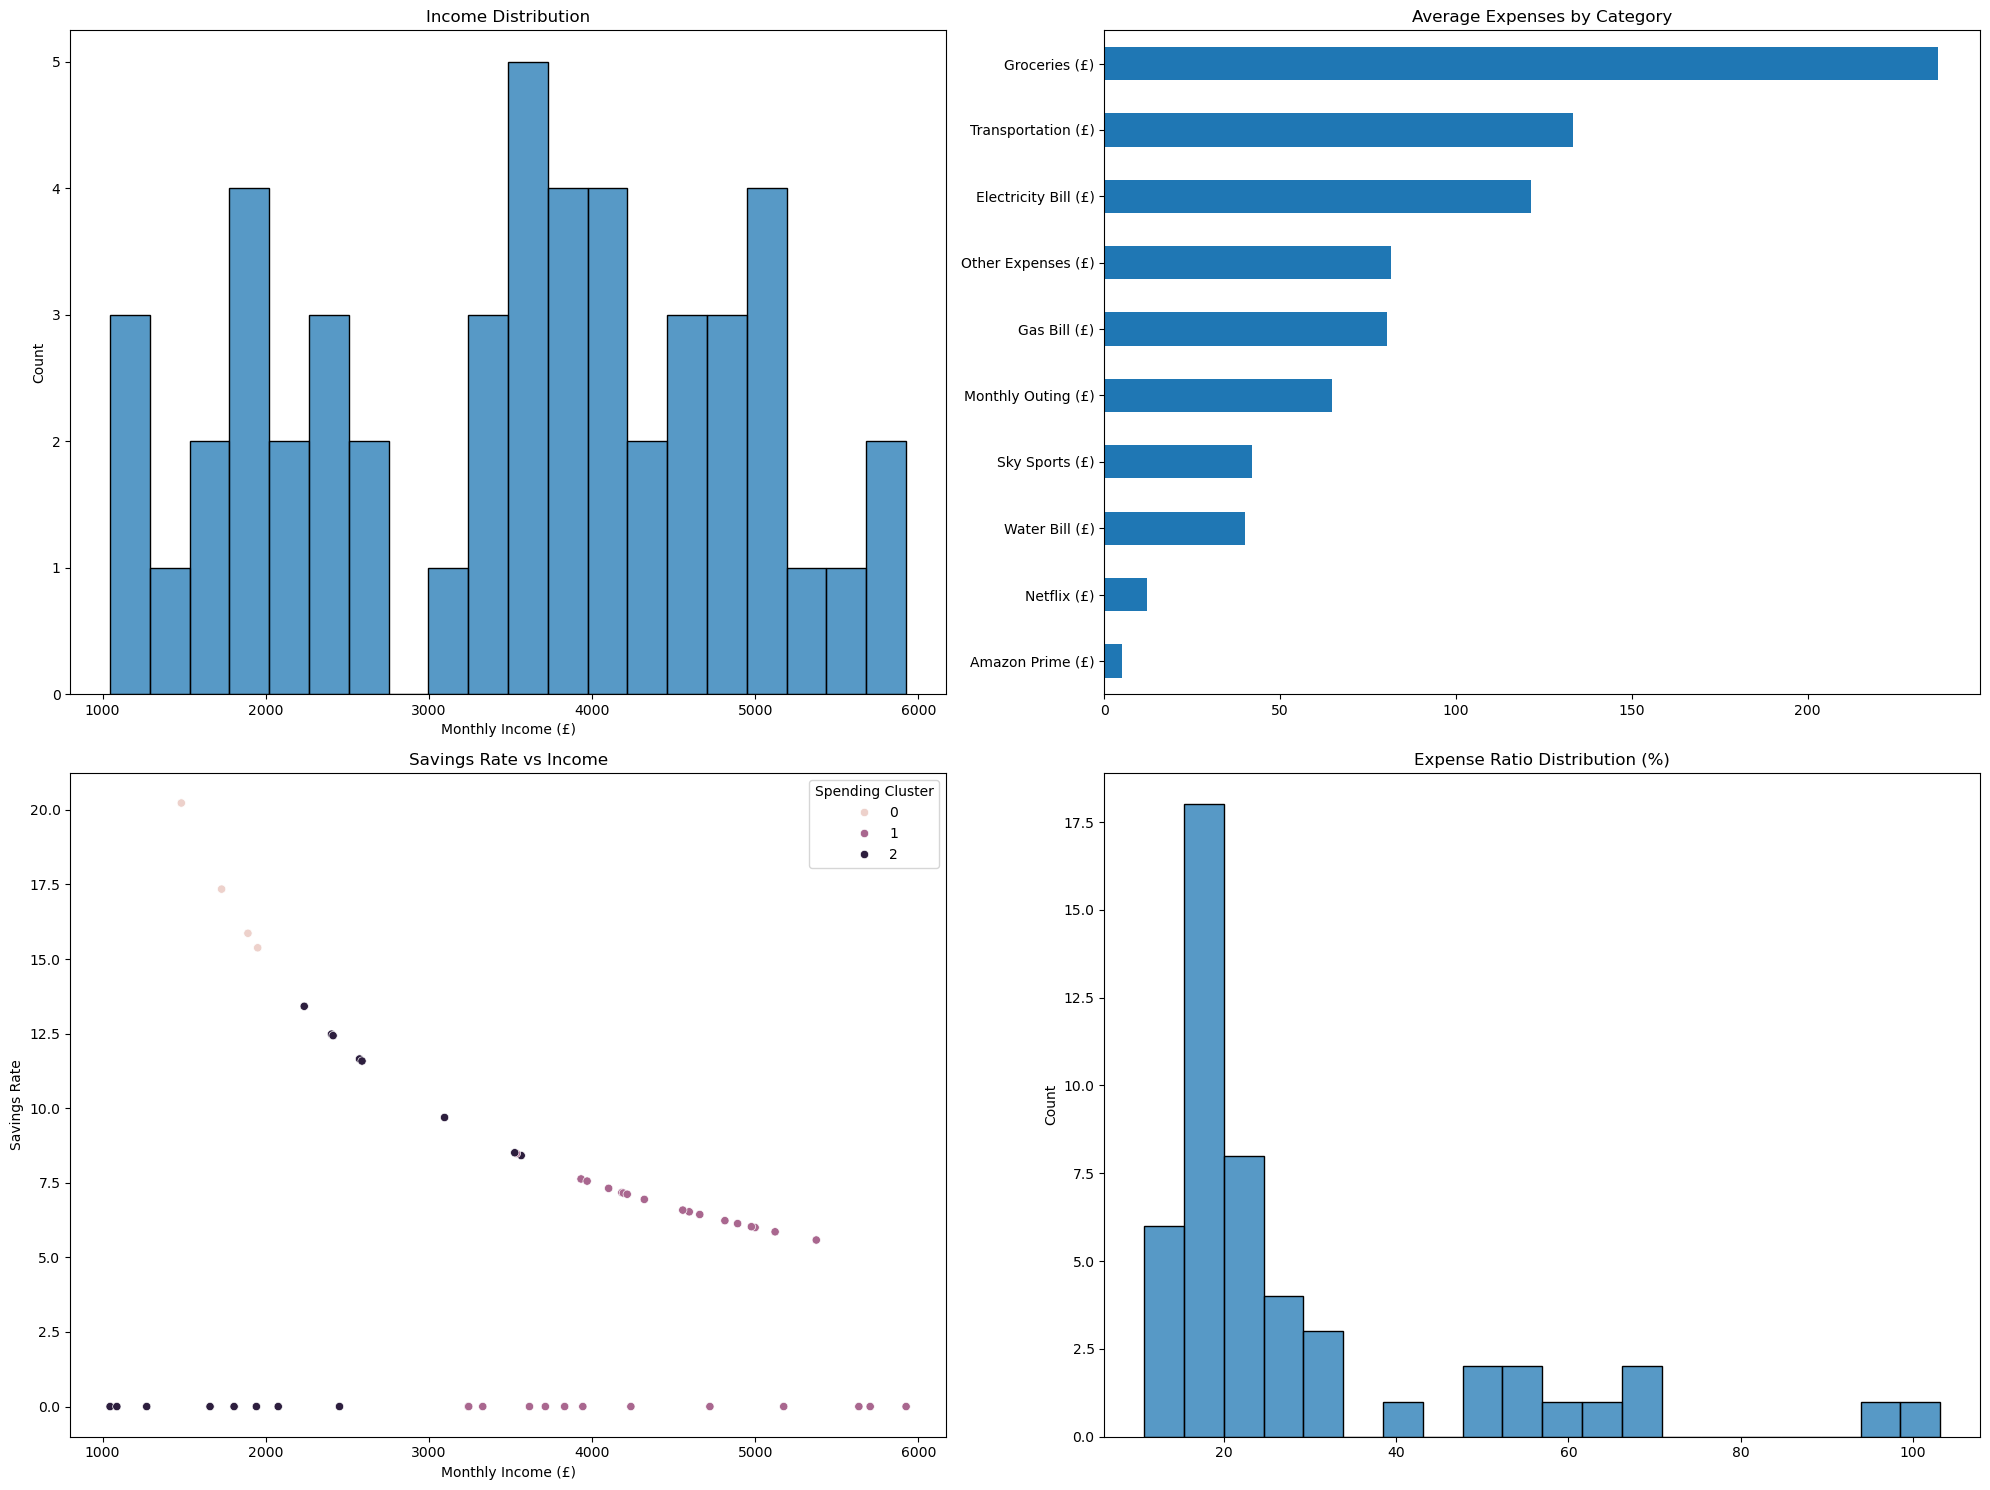

In [55]:
def create_visualizations(df):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Income Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Monthly Income (£)', bins=20)
    plt.title('Income Distribution')
    
    # 2. Expenses by Category
    plt.subplot(2, 2, 2)
    expense_columns = [col for col in df.columns if '(£)' in col and col not in ['Monthly Income (£)', 'Savings for Property (£)']]
    expenses_mean = df[expense_columns].mean().sort_values(ascending=True)
    expenses_mean.plot(kind='barh')
    plt.title('Average Expenses by Category')
    
    # 3. Savings Rate vs Income
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=df, x='Monthly Income (£)', y='Savings Rate', hue='Spending Cluster')
    plt.title('Savings Rate vs Income')
    
    # 4. Expense Ratio Analysis
    plt.subplot(2, 2, 4)
    expense_ratio = (df['Total Expenses'] / df['Monthly Income (£)']) * 100
    sns.histplot(expense_ratio, bins=20)
    plt.title('Expense Ratio Distribution (%)')
    
    plt.tight_layout()
    return fig

fig = create_visualizations(df)

### Calculate Correlation Matrix

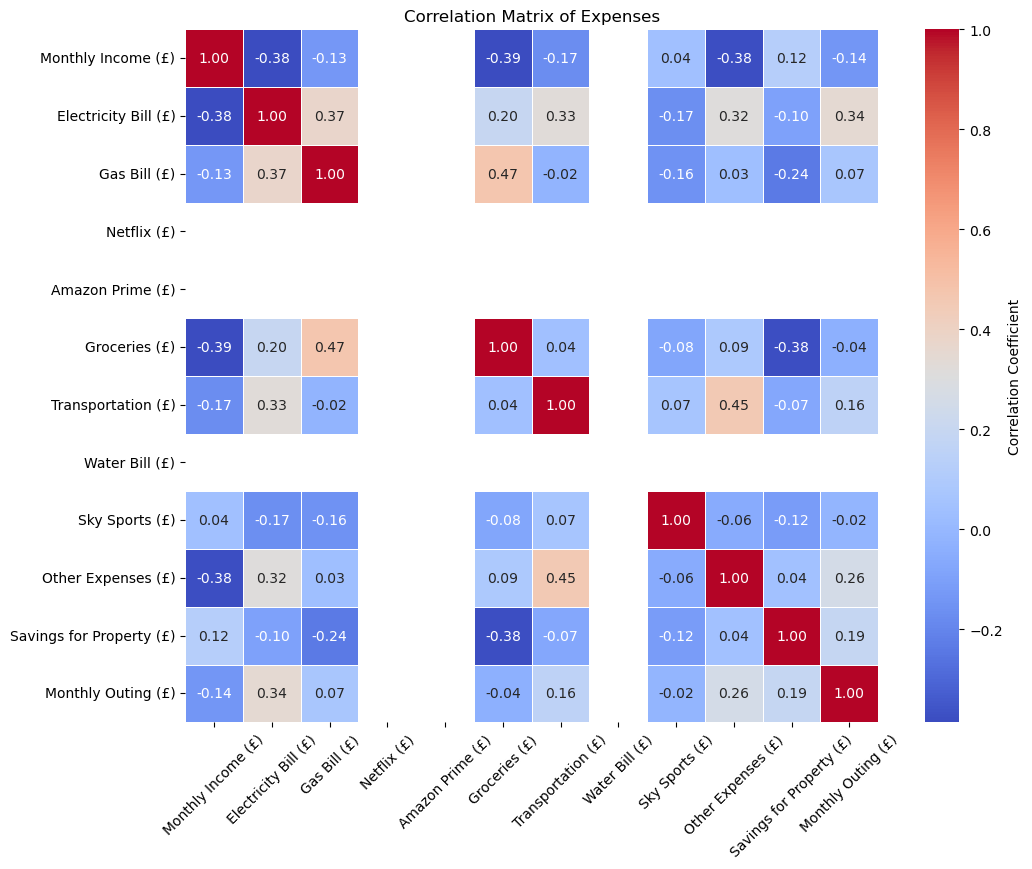

In [60]:
def calculate_correlation_matrix(df):
    #Categories of expenses
    expense_columns = [col for col in df.columns if '(£)' in col and col not in ['Employee']]

    # Calculate the correlation matrix
    correlation_matrix = df[expense_columns].corr()
    
    # Create a heatmap
    plt.figure(figsize=(12, 9))
    sns.heatmap(correlation_matrix, 
                annot=True, cmap='coolwarm', 
                fmt=".2f", 
                annot_kws={'size': 10}, 
                square=True,  
                linewidth=0.5, 
                cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix of Expenses')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
correlation_matrix = calculate_correlation_matrix(df)